<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/GP_PROYECTO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

In [5]:
#Cargar la dataset
data = pd.read_csv('/content/datos_viento.xlsx - Export.csv')

In [6]:
#Correccion de datos
data.dropna(subset=['date', 'wspd'], inplace=True)
data['wspd'] = data['wspd'].str.replace(',', '.').astype(float)
data['date'] = pd.to_datetime(data['date']).astype(int) / 10**9  # Fechas en formato numérico (segundos desde época Unix)

In [7]:
#caracteristicas
X = data['date'].values.reshape(-1, 1)
y = data['wspd'].values.reshape(-1, 1)


In [8]:
#Normalizar datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#Dividir los datos
rs = ShuffleSplit(n_splits=1, random_state=42, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X_scaled)):
    X_train, X_test, y_train, y_test = X_scaled[train_i], X_scaled[test_i], y[train_i], y[test_i]

In [10]:
# Definir el Kernel
kernel = 1.0 * RBF(length_scale=1.0) + 1.0 * DotProduct(sigma_0=1.0) + 1.0 * ExpSineSquared(length_scale=1.0, periodicity=1.0)

In [11]:
# Crear el modelo Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-1, random_state=0)

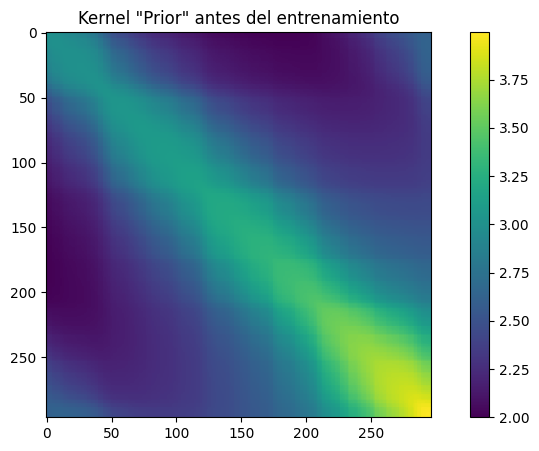

In [12]:
#kernel prior
X_test_sorted = np.sort(X_test, axis=0)
K_prior = kernel(X_test_sorted)
plt.figure(figsize=(10, 5))
plt.imshow(K_prior, interpolation='nearest')
plt.title('Kernel "Prior" antes del entrenamiento')
plt.colorbar()
plt.show()


In [13]:
#Entrenar el GP
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.1,
                         kernel=1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1),
                         random_state=0)

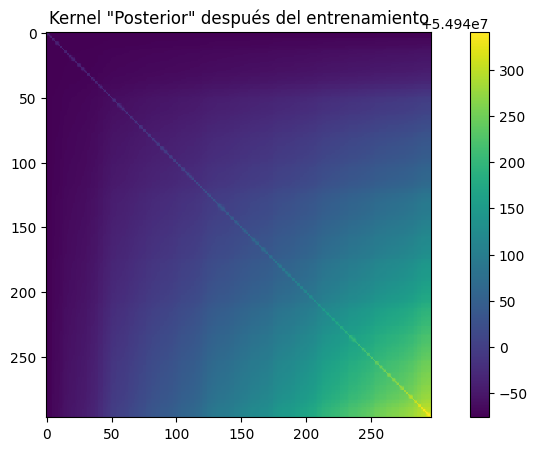

In [14]:
#kernel posterior
K_posterior = gpr.kernel_(X_test_sorted)
plt.figure(figsize=(10, 5))
plt.imshow(K_posterior, interpolation='nearest')
plt.title('Kernel "Posterior" después del entrenamiento')
plt.colorbar()
plt.show()

In [15]:
# Hacer predicciones y obtener la desviación estándar
y_mean, y_std = gpr.predict(X_test_sorted, return_std=True)

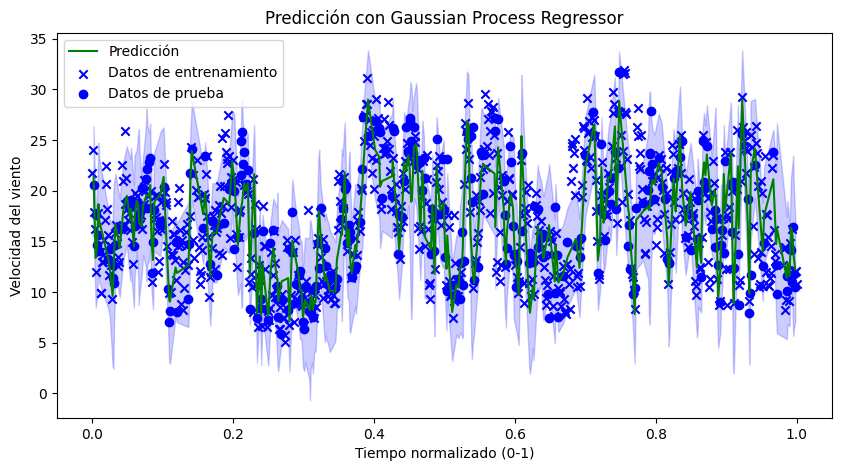

In [17]:
# Grafica prediccion
plt.figure(figsize=(10, 5))
plt.plot(X_test_sorted, y_mean, 'g-', label='Predicción')
plt.fill_between(X_test_sorted.ravel(), y_mean.ravel() - 1.96 * y_std, y_mean.ravel() + 1.96 * y_std, color='b', alpha=0.2)
plt.scatter(X_train, y_train, c='b', marker='x', label='Datos de entrenamiento')
plt.scatter(X_test, y_test, c='b', marker='o', label='Datos de prueba')
plt.xlabel('Tiempo normalizado (0-1)')
plt.ylabel('Velocidad del viento')
plt.legend(loc='upper left')
plt.title('Predicción con Gaussian Process Regressor')
plt.show()


In [18]:
# Mostrar el kernel y sus hiperparámetros después del entrenamiento
print("Kernel posterior a entrenamiento:", gpr.kernel_)

Kernel posterior a entrenamiento: 5.97**2 * RBF(length_scale=0.00171) + 19.5**2 * DotProduct(sigma_0=380) + 1.73**2 * ExpSineSquared(length_scale=0.000406, periodicity=0.000194)
